# SVM Classification

Predicting if recipe reviews are positive or negative.

Dataset: https://www.kaggle.com/hugodarwood/epirecipes

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

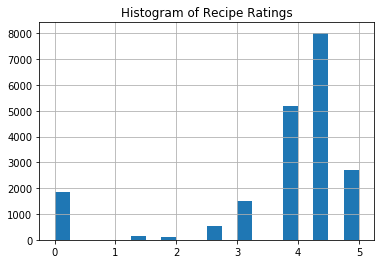

In [5]:
# visualize distribution of reviews
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [6]:
# Find columns with null values 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [7]:
# creating a new dataframe without the missing values
# dropping title because object type - won't work in model

df = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)

In [8]:
# turning this into a classification problem
# split reviews based on mean of rating
# finding mean of ratings
mean_rating = raw_data['rating'].mean()

#creating new column where ratings are 1 for good and 0 for bad
df['target'] = np.where(raw_data['rating']>=mean_rating, 1, 0)

#printing mean value
mean_rating

3.714467384799521

In [9]:
# checking size of each option
# many more good than bad reviews
df.target.value_counts()

1    15907
0     4145
Name: target, dtype: int64

In [10]:
#checking correlation of columns to the target
corr_matrix = df.corr()

#dropping highly correlated features
#code from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print('Columns to drop: ' , (len(to_drop)))

# Drop features 
df = df.drop(columns=to_drop)
print('train_features_df shape: ', df.shape)

Columns to drop:  8
train_features_df shape:  (20052, 667)


In [11]:
# get positively correlated features
pos_corr = corr_matrix['target'].sort_values(ascending=False).head(20)

#converting to dataframe
pos_corr = pd.DataFrame(pos_corr)
pos_corr

,target
target,1.000000
bon appétit,0.119923
sauté,0.067372
peanut free,0.065987
bake,0.065165
roast,0.063498
soy free,0.063235
fall,0.059346
tree nut free,0.057293
winter,0.053013


In [12]:
# get list of column names
top_pos = [column for column in pos_corr.columns]

# create new column with sum across rows if in list
df['top_pos_tags'] = df[top_pos].sum(axis=1)

In [13]:
# get negatively correlated features
# interesting ...alcoholic recipes don't seem to get good reviews!
neg_corr = corr_matrix['target'].sort_values(ascending=True).head(20)

# convert to dataframe
neg_corr = pd.DataFrame(neg_corr)
neg_corr

,target
drink,-0.185631
alcoholic,-0.174089
house & garden,-0.164791
gin,-0.140325
cocktail party,-0.110230
cocktail,-0.108790
spirit,-0.106322
bitters,-0.098961
harpercollins,-0.084260
rum,-0.074016


In [14]:
# get list of column names
top_neg = [column for column in neg_corr.columns]

# create new column with sum across rows if in list
df['top_neg_tags'] = df[top_neg].sum(axis=1)

In [15]:
# create new column with sum of tags for each recipe
df['sum_tags'] = df.sum(axis=1)
df.head()

,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,...,yuca,zucchini,cookbooks,leftovers,snack,turkey,target,top_pos_tags,top_neg_tags,sum_tags
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,11.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,14.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,10.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,17.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,11.0


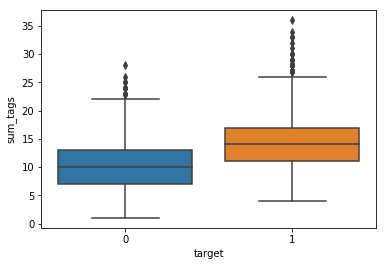

In [16]:
# it looks like our positive reviews have more tags than negative reviews
sns.boxplot(x=df.target, y=df.sum_tags);

In [21]:
# trying the model
from sklearn.svm import SVR
svr = SVR()
X = df[['top_pos_tags', 'top_neg_tags', 'sum_tags']]
y = df['target']
svr.fit(X,y)

y_ = svr.predict(X)

svr.score(X, y)

0.9390178718991129

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, y, cv=5)

array([0.937194  , 0.93970643, 0.9375    , 0.93961206, 0.94084162])